# aim: for MFR- a function to depth-integrate phytoplankton from ptrc output and find dominant species

requires only xarray

# date: 2025-06-02

In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')


In [2]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [ ]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

## function to depth-integrate phytoplankton and find dominant species

takes as input a string identifying directory where model output is, another string identifying the ptrc .nc that we are finding dominant phytoplankton for. 

it then depth-integrates all phytoplankton species and finds the most abundant one, which it returns as an integer 1-6, 
1 = DIA, 2 = MIX, 3 = COC, 4 = PHA, 5 = FIX, 6 = PIC

saves depth-integrated phytoplankton and dominant species as .nc in user-specified directory

In [97]:
def integrate_and_identify_dominant_phytoplankton(tdir, tfil, sdir, species_order=None):
        
    """
    Converts mol/L to mol/m³, depth-integrates selected phytoplankton species to mol/m²,
    and adds a variable indicating the dominant species at each point.

    Parameters:
    -----------
    tdir : directory of model output
    
    tfil : ptrc file with phytoplankton concentrations
    
    sdir : directory in which to save output

    species_order : list of str, optional
        List of species names to include and order. Defaults to ['DIA', 'MIX', 'COC', 'PHA', 'FIX', 'PIC']

    Returns:
    --------
    xr.Dataset
        Dataset with:
          - 6 depth-integrated species (mol/m², NaN where land)
          - 'dominant_species' variable (int, 1–6) or NaN where top layer is zero
    """
    
    print(f'depth-integrating phytoplankton and finding dominant species for:')
    print(f'{tdir}/{tfil}')
    phytoplankton = xr.open_dataset(f'{tdir}/{tfil}')
    tmesh = xr.open_dataset('/gpfs/data/greenocean/software/resources/regrid/mesh_mask3_6.nc')
    snam = tfil.replace("ptrc", "depthint_dom")
    snam = f'{sdir}/{snam}'
    
    if species_order is None:
        species_order = ['DIA', 'MIX', 'COC', 'PHA', 'FIX', 'PIC']

    # Convert units: mol/L → mol/m³
    selected = phytoplankton[species_order] * 1000

    # Rename tmesh dimensions to match
    e3t = tmesh['e3t_0'].rename({'t': 'time_counter', 'z': 'deptht'})
    if e3t.sizes.get('time_counter', 1) == 1:
        e3t = e3t.squeeze('time_counter', drop=True)
        e3t = e3t.expand_dims(time_counter=phytoplankton.time_counter)

    # Broadcast to match phytoplankton dimensions
    e3t_broadcasted = xr.broadcast(selected, e3t)[1]

    # Depth-integrated values (mol/m²)
    integrated = (selected * e3t_broadcasted).sum(dim='deptht')

    # Add metadata
    for sp in species_order:
        integrated[sp].attrs['long_name'] = f'Depth-integrated {sp} phytoplankton concentration'
        integrated[sp].attrs['units'] = 'mol m-2'
        integrated[sp].attrs['note'] = 'Converted from mol/L to mol/m³ before integration using e3t_0 thickness'

    # Stack for dominant species determination
    stacked = xr.concat([integrated[sp] for sp in species_order], dim='species')
    stacked = stacked.assign_coords(species=np.arange(1, len(species_order) + 1))  # 1-based
    dominant = stacked.argmax(dim='species') + 1

    # Mask where top layer is zero for all species (i.e. land)
    top_layer = selected.isel(deptht=0)
    top_stacked = xr.concat([top_layer[sp] for sp in species_order], dim='species')
    top_zero_mask = (top_stacked == 0).all(dim='species')

    # Mask dominant species
    dominant = dominant.where(~top_zero_mask)

    # Mask integrated species
    for sp in species_order:
        integrated[sp] = integrated[sp].where(~top_zero_mask)

    # Add dominant_species to dataset
    integrated['dominant_species'] = dominant
    integrated['dominant_species'].attrs['long_name'] = 'Index of dominant phytoplankton species'
    integrated['dominant_species'].attrs['description'] = (
        '1 = DIA, 2 = MIX, 3 = COC, 4 = PHA, 5 = FIX, 6 = PIC; NaN = top grid cell is zero'
    )
    integrated['dominant_species'].attrs['note'] = (
        'Based on maximum depth-integrated biomass (mol m-2); '
        'NaN where top depth layer contains no biomass for all species'
    )
    
    try:
        integrated.to_netcdf(snam)
        print('---')
        print(f'saved to {snam}')
    except:
        print('---')
        print(f'did not save - potentially {snam} already exists')

    return integrated


## example: how to use function

In [98]:
## directory with model output
tdir = '/gpfs/data/greenocean/software/runs/TOM12_TJ_R4A0/'
## file to calculate for
tfil = 'ORCA2_1m_19710101_19711231_ptrc_T.nc'
sdir = './data/'

calculate = True
if calculate:
    integ = integrate_and_identify_dominant_phytoplankton(tdir, tfil, sdir)

depth-integrating phytoplankton and finding dominant species for:
/gpfs/data/greenocean/software/runs/TOM12_TJ_R4A0//ORCA2_1m_19710101_19711231_ptrc_T.nc
---
did not save - potentially ./data//ORCA2_1m_19710101_19711231_depthint_dom_T.nc already exists


HDF5-DIAG: Error detected in HDF5 (1.10.4) thread 47372010006656:
  #000: H5F.c line 444 in H5Fcreate(): unable to create file
    major: File accessibilty
    minor: Unable to open file
  #001: H5Fint.c line 1364 in H5F__create(): unable to open file
    major: File accessibilty
    minor: Unable to open file
  #002: H5Fint.c line 1579 in H5F_open(): unable to truncate a file which is already open
    major: File accessibilty
    minor: Unable to open file


## quick plot of output

In [106]:
tdir = '/gpfs/data/greenocean/software/runs/TOM12_TJ_R4A0/'
tfil = 'ORCA2_1m_19710101_19711231_ptrc_T.nc'
## original model output
phyto = xr.open_dataset(f'{tdir}{tfil}')
## integrated phytoplankton concentrations + identified dominant species
integ = xr.open_dataset('/gpfs/home/mep22dku/scratch/PRONG3/data/ORCA2_1m_19710101_19711231_depthint_dom_T.nc')
## meshmask
tmesh = xr.open_dataset('/gpfs/data/greenocean/software/resources/regrid/mesh_mask3_6.nc')

Text(0.5, 0.98, 'depth integrated phytoplankton (mol/m2) and dominant species for month 5 \n /gpfs/data/greenocean/software/runs/TOM12_TJ_R4A0/ORCA2_1m_19710101_19711231_ptrc_T.nc')

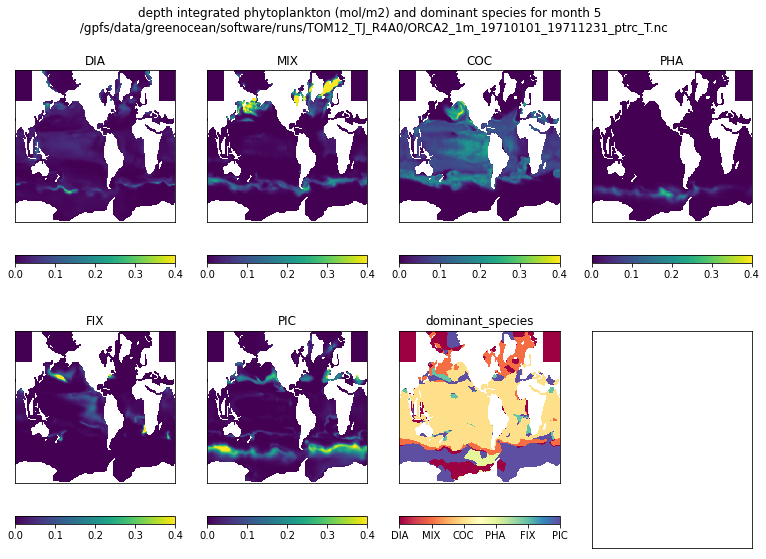

In [101]:
month = 4 # may, 5 - 1 (python indexing)

fact = 1.1
fig, axs = plt.subplots(2,4, figsize=(12*fact, 8*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()

tvars = ['DIA', 'MIX', 'COC', 'PHA', 'FIX', 'PIC','dominant_species']
tmax = 0.4

for i in range(0,7):
    
    tvar = tvars[i]
    if i < 6: tcmap = 'viridis'
    else: tcmap = 'Spectral'
    
    if i < 6:
        w = axs[i].pcolormesh(integ[tvar][month,:,:], cmap = tcmap, vmin = 0, vmax = tmax)
        cbar = plt.colorbar(w, ax = axs[i], orientation='horizontal')
        axs[i].set_title(f'{tvar}')
    
    if i == 6:
        w = axs[i].pcolormesh(integ[tvar][month,:,:], cmap = tcmap, vmin = 1, vmax = 6)
        cbar = plt.colorbar(w, ax = axs[i], orientation='horizontal')
        cbar.set_ticks(np.arange(1,7))
        cbar.set_ticklabels(['DIA', 'MIX', 'COC', 'PHA', 'FIX', 'PIC'])
        axs[i].set_title(f'{tvar}')
        
    axs[i].set_xticks([]); axs[i].set_yticks([])

axs[7].set_xticks([]); axs[7].set_yticks([])

plt.suptitle(f'depth integrated phytoplankton (mol/m2) and dominant species for month {month+1} \n {tdir}{tfil}')

## manual check that hand-integrating and the function give the same answer / that the dominant phytoplankton finder works as expected (yes)

In [102]:
y = 75; x = 40
tphy = 'PHA'
print(tphy)
print('manual integration')
print(np.nansum(phyto[tphy][0,:,y,x].values * tmesh['e3t_0'][0,:,y,x].values)*1000)
print('function output')
print(integ[tphy][0,y,x].values)


tphy = 'COC'
print(tphy)
print('manual integration')
print(np.nansum(phyto[tphy][0,:,y,x].values * tmesh['e3t_0'][0,:,y,x].values)*1000)
print('function output')
print(integ[tphy][0,y,x].values)
print()
print(integ.dominant_species[0,y,x].values)
print(integ.dominant_species.description)
print(integ.dominant_species.note)

PHA
manual integration
0.00018868408260758033
function output
0.00018868408215527393
COC
manual integration
0.08446321016180043
function output
0.08446321054514982

3.0
1 = DIA, 2 = MIX, 3 = COC, 4 = PHA, 5 = FIX, 6 = PIC; NaN = top grid cell is zero
Based on maximum depth-integrated biomass (mol m-2); NaN where top depth layer contains no biomass for all species


## dominant species based on seasonal (or annual) mean depth-integrated phytoplankton

takes an xarray dataset of the type that we calculated above (saved as, eg, `ORCA2_1m_19710101_19711231_depthint_dom_T.nc`), gets average depth-integrated phytoplankton for a season (or annually), and calculates dominant phytoplankton based on that seasonal (or annual) mean. 

In [113]:
def calculate_seasonal_mean_and_dominant(integrated, season='DJF', species_order=None):
    """
    Compute seasonal or annual mean and dominant phytoplankton species.

    Parameters:
    -----------
    integrated : xr.Dataset
        Output from integrate_and_identify_dominant_phytoplankton

    season : str
        'DJF', 'MAM', 'JJA', 'SON' = standard seasons
        'FY' = full-year (annual) mean

    species_order : list of str, optional
        Names of phytoplankton variables (default: 6 common)

    Returns:
    --------
    xr.Dataset
        Dataset with:
          - Seasonal or annual mean of each species (mol/m²)
          - dominant_species (int: 1–6, or NaN where biomass is zero)
    """
    if species_order is None:
        species_order = ['DIA', 'MIX', 'COC', 'PHA', 'FIX', 'PIC']

    # Select data based on season
    if season == 'FY':
        season_ds = integrated.load() 
        season_label = 'Full Year'
    else:
        season_ds = integrated.sel(time_counter=integrated['time_counter'].dt.season == season)
        season_label = season

    # Compute mean
    seasonal_mean = season_ds[species_order].mean(dim='time_counter', skipna=True)

    # Mask for all-NaN cases
    all_nan_mask = xr.concat([seasonal_mean[sp].isnull() for sp in species_order], dim='species').all(dim='species')

    # Stack and fill NaNs before argmax
    stacked = xr.concat(
        [seasonal_mean[sp].fillna(-1e20) for sp in species_order],
        dim='species'
    )
    stacked = stacked.assign_coords(species=np.arange(1, len(species_order) + 1))

    # Get dominant index, mask invalid
    dominant = stacked.argmax(dim='species') + 1
    dominant = dominant.where(~all_nan_mask)

    # Add to dataset
    seasonal_mean['dominant_species'] = dominant
    seasonal_mean['dominant_species'].attrs['long_name'] = f'Dominant phytoplankton species ({season_label} mean)'
    seasonal_mean['dominant_species'].attrs['description'] = (
        '1 = DIA, 2 = MIX, 3 = COC, 4 = PHA, 5 = FIX, 6 = PIC; NaN = no biomass in period'
    )

    # Add helpful note to each species
    for sp in species_order:
        seasonal_mean[sp].attrs['note'] = f'{season_label} mean of depth-integrated {sp} (mol m-2)'

    return seasonal_mean


## example use case - JJA (with visualization)

In [114]:
integ = xr.open_dataset('/gpfs/home/mep22dku/scratch/PRONG3/data/ORCA2_1m_19710101_19711231_depthint_dom_T.nc')
mean_jja = calculate_seasonal_mean_and_dominant(integ, season='JJA', species_order=None)

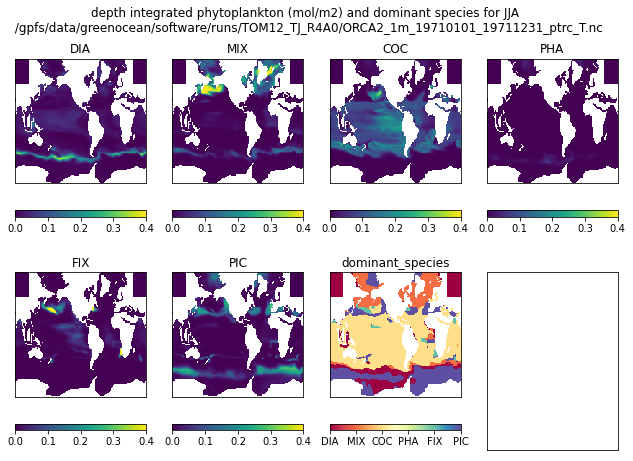

In [121]:
fact = 0.9
fig, axs = plt.subplots(2,4, figsize=(12*fact, 8*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()

tvars = ['DIA', 'MIX', 'COC', 'PHA', 'FIX', 'PIC','dominant_species']
tmax = 0.4

for i in range(0,7):
    
    tvar = tvars[i]
    if i < 6: tcmap = 'viridis'
    else: tcmap = 'Spectral'
    
    if i < 6:
        w = axs[i].pcolormesh(mean_jja[tvar][:,:], cmap = tcmap, vmin = 0, vmax = tmax)
        cbar = plt.colorbar(w, ax = axs[i], orientation='horizontal')
        axs[i].set_title(f'{tvar}')
    
    if i == 6:
        w = axs[i].pcolormesh(mean_jja[tvar][:,:], cmap = tcmap, vmin = 1, vmax = 6)
        cbar = plt.colorbar(w, ax = axs[i], orientation='horizontal')
        cbar.set_ticks(np.arange(1,7))
        cbar.set_ticklabels(['DIA', 'MIX', 'COC', 'PHA', 'FIX', 'PIC'])
        axs[i].set_title(f'{tvar}')
        
    axs[i].set_xticks([]); axs[i].set_yticks([])

axs[7].set_xticks([]); axs[7].set_yticks([])

q =plt.suptitle(f'depth integrated phytoplankton (mol/m2) and dominant species for JJA \n {tdir}{tfil}')

## example use case - full year with visualization (use 'FY' as input)

In [122]:
integ = xr.open_dataset('/gpfs/home/mep22dku/scratch/PRONG3/data/ORCA2_1m_19710101_19711231_depthint_dom_T.nc')
mean_fy = calculate_seasonal_mean_and_dominant(integ, season='FY', species_order=None)

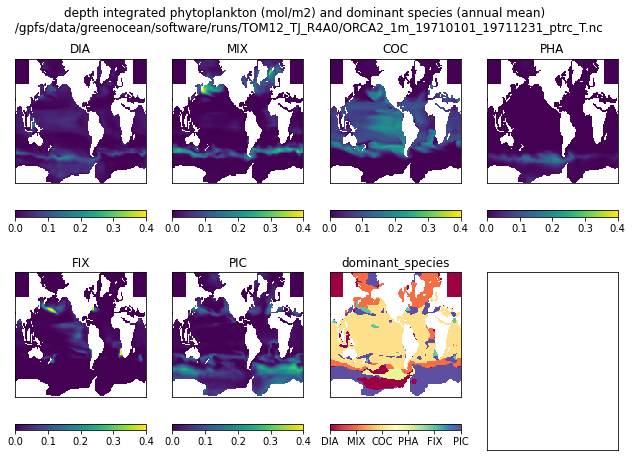

In [123]:

fig, axs = plt.subplots(2,4, figsize=(12*fact, 8*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()

tvars = ['DIA', 'MIX', 'COC', 'PHA', 'FIX', 'PIC','dominant_species']
tmax = 0.4

for i in range(0,7):
    
    tvar = tvars[i]
    if i < 6: tcmap = 'viridis'
    else: tcmap = 'Spectral'
    
    if i < 6:
        w = axs[i].pcolormesh(mean_fy[tvar][:,:], cmap = tcmap, vmin = 0, vmax = tmax)
        cbar = plt.colorbar(w, ax = axs[i], orientation='horizontal')
        axs[i].set_title(f'{tvar}')
    
    if i == 6:
        w = axs[i].pcolormesh(mean_fy[tvar][:,:], cmap = tcmap, vmin = 1, vmax = 6)
        cbar = plt.colorbar(w, ax = axs[i], orientation='horizontal')
        cbar.set_ticks(np.arange(1,7))
        cbar.set_ticklabels(['DIA', 'MIX', 'COC', 'PHA', 'FIX', 'PIC'])
        axs[i].set_title(f'{tvar}')
        
    axs[i].set_xticks([]); axs[i].set_yticks([])

axs[7].set_xticks([]); axs[7].set_yticks([])

q = plt.suptitle(f'depth integrated phytoplankton (mol/m2) and dominant species (annual mean) \n {tdir}{tfil}')